### 1.필요한 라이브러리 임포트

In [1]:
import os
from glob import glob
from PIL import Image

import numpy as np
import tensorflow as tf
import random

import matplotlib.pyplot as plt

### 2.이미지 파일 가져오기

In [2]:
# 이미지 패스 확인
data_dir = './concrete_image/'

In [3]:
# 이미지 폴더 밑의 폴더 확인

!ls -l ./concrete_image

total 0
drwxr-xr-x@ 2002 idaeyong  staff  64064 May 27 23:47 Negative
drwxr-xr-x@ 2002 idaeyong  staff  64064 May 27 23:47 Positive


In [4]:
# daisy 폴더 안의 이지미 갯수
!ls -l ./concrete_image/Negative | grep jpg | wc -l

    2000


In [5]:
# daisy 폴더 안의 이지미 갯수
!ls -l ./concrete_image/Positive | grep jpg | wc -l

    2000


### 3. os.listdir과 PIL.Image 이용하여 이미지 읽기

In [6]:
# 이미지 패스 지정
negative_path = './concrete_image/Negative/'
positive_path = './concrete_image/Positive/'

In [7]:
# 이미지 패스의 파말 리스트 만들기
negative_file = os.listdir(negative_path)
positive_file = os.listdir(positive_path)

In [8]:
# 이미지 파일 리스트 읽어보기
negative_file[:2], positive_file[:2]

(['00132.jpg', '00654.jpg'], ['00132.jpg', '00654.jpg'])

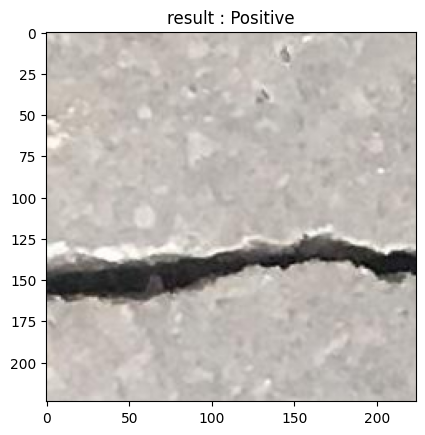

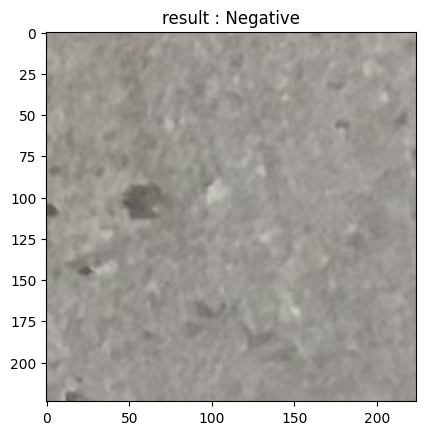

In [9]:
# 위의 파일 리스트에서 2개씩 읽고 이미지 출력하기
positive_ran_num = random.randint(1, len(positive_file))
negative_ran_num = random.randint(1, len(negative_file))

img = Image.open(positive_path + positive_file[positive_ran_num]).resize((224,224))
plt.title("result" + ' : Positive')
plt.imshow(img)
plt.show()

img = Image.open(negative_path + negative_file[negative_ran_num]).resize((224,224))
plt.title("result" + ' : Negative')
plt.imshow(img)
plt.show()

### 4. 이미지 라벨링 포함해서 Class별 이미지 리스트 만들기

In [10]:
# Class 라벨 정의

class2idx = {'negative' :  0, 'positive' : 1}
idx2class = {0 : 'negative', 1 : 'positive'}


In [11]:
# 수작업으로 이미지 리스트와 라벨 리스트 만들기

img_list = []
label_list = []

negative_file = os.listdir(negative_path)
for img_file in negative_file :
  img = Image.open(negative_path + img_file).resize((128,128))
  img = np.array(img)/255.  # 이미지 스케일링
  img_list.append(img)
  label_list.append(0) # negative : 0

positive_file = os.listdir(positive_path)
for img_file in positive_file :
  img = Image.open(positive_path + img_file).resize((128,128))
  img = np.array(img)/255.  # 이미지 스케일링
  img_list.append(img)
  label_list.append(1) # positive : 1

In [12]:
# 이미지 리스트, 라벨 리스트루 numpy array 변경
img_list_arr = np.array(img_list)
label_list_arr = np.array(label_list)

In [13]:
# 이미지 리스트, 라벨 리스트 shape 확인
img_list_arr.shape, label_list_arr.shape

((4000, 128, 128, 3), (4000,))

### 5. Train/Test 데이터셋 만들기

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(img_list_arr, label_list_arr, test_size=0.3, stratify=label_list_arr, random_state=41)
X_train.shape, X_test.shape , y_train.shape, y_test.shape

((2800, 128, 128, 3), (1200, 128, 128, 3), (2800,), (1200,))

## B. Build Model

### 1. Build Model

In [15]:
# Hyperparameter Tunning

num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (128, 128, 3)  # 사이즈 확인

In [16]:
# Sequential 모델 정의
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64,(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
import tf_keras

In [18]:
# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])  # Metrics / Accuracy

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,400,069 (32.04 MB)

 Trainable params: 8,400,069 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

### 2. Callback

In [26]:
# callback : EarlyStopping, ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=my_checkpoint.h5

### 3. 모델 학습

In [22]:
# num_epochs = 10
# batch_size = 32

# 모델 학습(fit)
history = model.fit(
    X_train, y_train ,
    validation_data=(X_test, y_test),
    epochs=2,
    batch_size=batch_size,
    callbacks=[es, checkpoint]
)

Epoch 1/2
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5935 - loss: 1.2189
Epoch 1: val_loss improved from inf to 0.16049, saving model to my_checkpoint.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.5954 - loss: 1.2121 - val_accuracy: 0.9292 - val_loss: 0.1605
Epoch 2/2
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9655 - loss: 0.1058
Epoch 2: val_loss improved from 0.16049 to 0.05604, saving model to my_checkpoint.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - accuracy: 0.9656 - loss: 0.1056 - val_accuracy: 0.9808 - val_loss: 0.0560


### 5. Predict

In [23]:
# Test 데이터로 성능 예측하기
test_ran_num = random.randint(1, len(X_test))

i=10
# pred_list = []

# for img, label in zip(X_test[:len(X_test)], y_test[:len(X_test)]):
    # 모델 예측(predict)
pred = model.predict(X_test[i].reshape(-1,128, 128, 3))
pred_t = np.argmax(pred)
#     pred_list.append(pred_t)
#     if label == pred_t :
#         i += 1

# print("Accuracy : " + str(i/len(X_test)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [24]:
pred_t

0

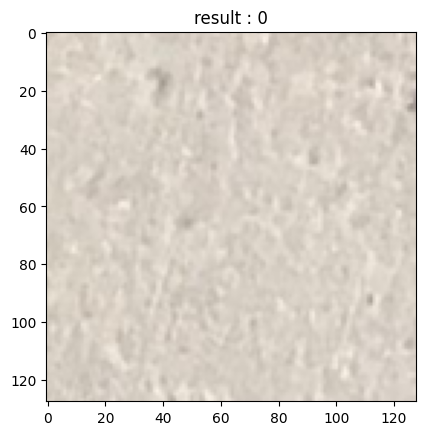

In [25]:
plt.title("result : " + str(pred_t))
plt.imshow(X_test[i])
plt.show()

In [ ]:
pred_t

In [ ]:
y_test[i]

### image_dataset_from_directory 이용하여 자동으로 이미지 데이터셋 생성, 라벨링 한꺼번에 처리 할수 있다.

In [16]:
# 하이터 파라미터 정의
input_shape = (224, 224, 3)
batch_size = 32
num_classes = 2

In [17]:
# 이미지 패스 지정
img_path ='./concrete_image/'

In [18]:
# image_dataset_from_directory 함수 활용하여
# 이미지 폴더 밑의 이미지들에 대해 원핫인코딩된 labeling수행, 이미지 배치, 셔플 수행

# Train Dataset 만들기
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

# TrastDataset 만들기
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory=img_path,
                                             label_mode="categorical",   # binary , categorical
                                             batch_size=batch_size,
                                             image_size=(224, 224),      # 사이즈 확인
                                             seed=42,
                                             validation_split=0.2,
                                             subset="validation"    # One of "training" or "validation". Only used if validation_split is set.
                                            )

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


In [19]:
# Class 이름 확인
train_ds.class_names

['Negative', 'Positive']

In [20]:
# 40,000건 중에서 32,000건 Train 사용. test용으로 8,000건 사용
len(train_ds) * 32 , len(test_ds) * 32

(3200, 800)

In [21]:
batch_img, batch_label = next(iter(train_ds))
batch_img.shape, batch_label.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 2]))

(224, 224, 3)


2024-05-28 00:01:09.190336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


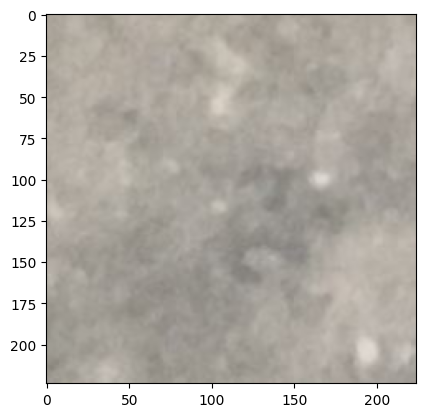

In [22]:
# 샘플 이미지 확인

i = 0
for batch_img, batch_label in train_ds.take(1):
  if i == 0 :
    print(batch_img[i].shape)
    plt.imshow(batch_img[i]/255)
  i = i + 1


## B. 모델링

### 1. Build Model

In [23]:
# Hyperparameter Tunning

num_epochs = 10
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.5

input_shape = (224, 224, 3)  # 사이즈 확인
num_classes = 2

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling

model = Sequential()
model.add(Rescaling(1. / 255))  # 이미지 Rescaling. 없이 하면 성능이 안나옴.
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64,(2,2), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

In [33]:
# Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='sparse_categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])  # Metrics / Accuracy

### 2. Callback

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

### 3. 모델 학습

In [35]:
# image_dataset_from_directory 이용하여 데이터 만들었을때 아래와 같이 학습 진행
# num_epochs = 10

# 모델 학습(fit)
history = model.fit(
    train_ds,
    validation_data=(test_ds),
    epochs=10,
    callbacks=[es, checkpoint]
)

Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 2), output.shape=(None, 2)

### 5. Predict

In [ ]:
len(test_ds) * 32

In [ ]:
# 배치사이즈 이미지/라벨 가져오기
batch_img , batch_label = next(iter(test_ds))
type(batch_img), batch_img.shape

In [ ]:
# Test 데이터로 성능 예측하기

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1


### 1. Build Model

In [49]:
# 케라스 applicatioins에 어떤 종류의 모델 있는지 확인
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'convnext',
 'densenet',
 'efficientnet',
 'efficientnet_v2',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nas

In [50]:
# 사전 훈련된 모델 MobileNetV2에서 기본 모델을 생성합니다.
# 아래와 같은 형식을 MobileNetV2 Transfer Learning 사용하며 됩니다.

base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [51]:
base_model.summary()

Model: "MobilenetV3large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_7[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [52]:
# tf.keras.applications.MobileNetV2 모델은 [-1, 1]의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 [0, 255]입니다.
# MobileNetV2 모델에서 제대로 수행하기 위해 크기를 [-1, 1]로 재조정해야 합니다.(안하고 수행해도 성능 잘 나옴)
# 방법 2가지 있음
# 첫번째 방법 : preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# 두번째 방법 : rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [53]:
# MobileNet V2 베이스 모델 고정하기
base_model.trainable = False

In [54]:
# 모델 구축 : 이미지 픽셀값 조정 수행하기(Rescaling) --> 성능 더 잘 나옴.

inputs = tf.keras.Input(shape=(224, 224, 3))
rescaling_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)
model_layer = base_model(rescaling_layer, training=False)
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(model_layer)  # 3차원(7, 7, 1280) --> 1차원(1280)으로 줄이기 : GlobalAveragePooling2D
output = tf.keras.layers.Dense(2, activation='softmax')(pooling_layer)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │         1,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,998,274 (11.44 MB)

 Trainable params: 1,922 (7.51 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [55]:
# 모델 compile

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),  # Optimization
              loss='categorical_crossentropy',  # Loss Function
              metrics=['accuracy'])             # Metrics / Accuracy

### 2. Callback

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# ModelCheckpoint
checkpoint_path = "my_checkpoint.keras"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=checkpoint.weights.h5

### 3. 모델 학습

In [58]:
# image_dataset_from_directory 이용하여 DataSet을 만들었으며
# num_epochs = 10
# batch_size = 32

history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=10,
    callbacks=[es, checkpoint]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9128 - loss: 0.2994
Epoch 1: val_loss improved from 0.30072 to 0.26945, saving model to my_checkpoint.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.9128 - loss: 0.2993 - val_accuracy: 0.9300 - val_loss: 0.2694
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9195 - loss: 0.2731
Epoch 2: val_loss improved from 0.26945 to 0.24692, saving model to my_checkpoint.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.9195 - loss: 0.2731 - val_accuracy: 0.9275 - val_loss: 0.2469
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9252 - loss: 0.2539
Epoch 3: val_loss improved from 0.24692 to 0.22912, saving model to my_checkpoint.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.9252 - loss: 0.2539 - val_accuracy: 0.9362 - val_loss: 0.2291
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9331 - loss: 0.2330

KeyboardInterrupt: 

In [60]:
# test_generator 샘플 데이터 가져오기
# 배치 사이즈 32 확인

batch_img, batch_label = next(iter(test_ds))
print(batch_img.shape)
print(batch_label.shape)

(32, 224, 224, 3)
(32, 2)


In [61]:
# 이미지 rescale 되어 있는 상태
batch_img[0][0][:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[203.9933 , 193.9933 , 181.9933 ],
       [203.99316, 193.99316, 181.99316],
       [203.88638, 193.88638, 181.88638],
       [200.89955, 190.89955, 178.89955],
       [198.93384, 188.93384, 176.93384],
       [198.15402, 188.15402, 176.15402],
       [200.18138, 190.18138, 178.18138],
       [201.7134 , 191.7134 , 179.7134 ],
       [199.36603, 189.36603, 177.36603],
       [202.38669, 192.38669, 180.38669]], dtype=float32)>

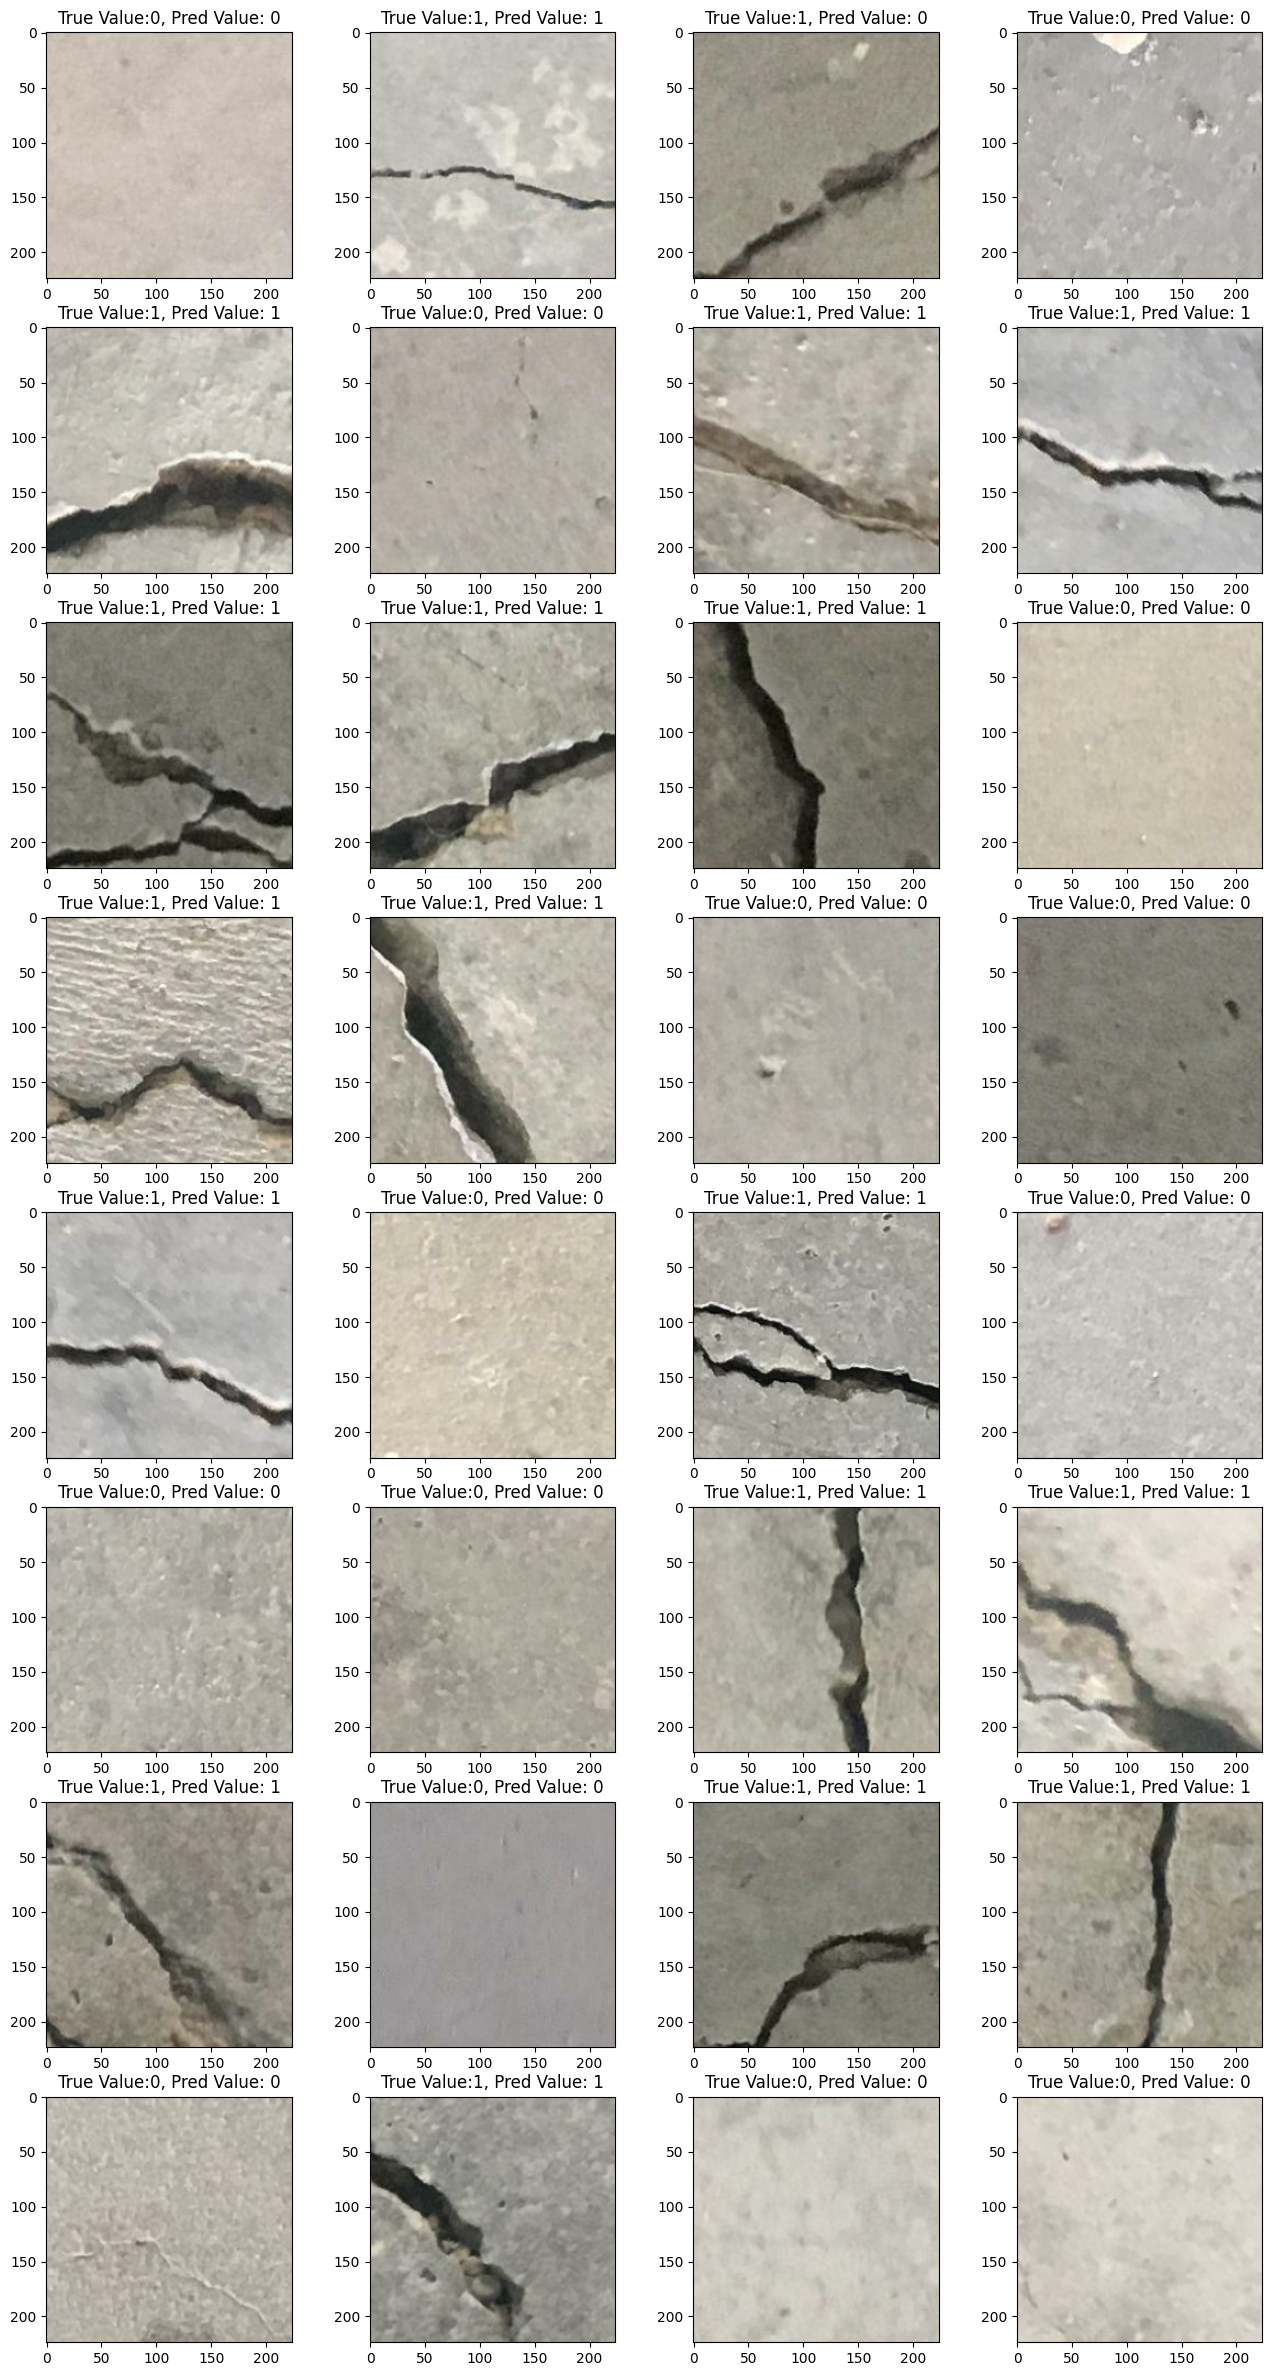

In [62]:
# 100% 성능 보여줌

i = 1
plt.figure(figsize=(16, 30))
for img, label in list(zip(batch_img, batch_label)):
    pred = model.predict(img.numpy().reshape(-1, 224,224,3), verbose=0)
    pred_t = np.argmax(pred)
    plt.subplot(8, 4, i)
    plt.title(f'True Value:{np.argmax(label)}, Pred Value: {pred_t}')
    plt.imshow(img/255)  # 이미지 픽셀값들이 실수형이므로 0~1 사이로 변경해야 에러 안남
    i = i + 1

In [64]:
model.save_weights('./best.weights.h5')